In [52]:
# 0.1 Imports & config
import os, gc, warnings, json, textwrap
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# Optional: imbalanced learning
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

pd.set_option("display.max_columns", 200)
sns.set_theme(context="notebook", style="whitegrid")


In [53]:
# 2.1 Paths (edit if needed)
APP_PATH = "C:/dataanalyticsproject/archive (10)/application_data.csv"
PREV_PATH = "C:/dataanalyticsproject/archive (10)/previous_application.csv"
DESC_PATH = "C:/dataanalyticsproject/archive (10)/columns_description.csv"  # optional

# 2.2 Load
app = pd.read_csv(APP_PATH, on_bad_lines='skip')
print("application_data:", app.shape)
app.head(3)

application_data: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [54]:
# 2.4 Peek meta
info = []
for c in app.columns[:]:
    missing = app[c].isna().mean()
    dtype = app[c].dtype
    info.append((c, str(dtype), round(missing,4)))
meta = pd.DataFrame(info, columns=["column","dtype","missing_rate"]).sort_values("missing_rate", ascending=False)
meta.head(20)


,column,dtype,missing_rate
48,COMMONAREA_AVG,float64,0.6987
62,COMMONAREA_MODE,float64,0.6987
76,COMMONAREA_MEDI,float64,0.6987
84,NONLIVINGAPARTMENTS_MEDI,float64,0.6943
70,NONLIVINGAPARTMENTS_MODE,float64,0.6943
56,NONLIVINGAPARTMENTS_AVG,float64,0.6943
86,FONDKAPREMONT_MODE,object,0.6839
54,LIVINGAPARTMENTS_AVG,float64,0.6835
82,LIVINGAPARTMENTS_MEDI,float64,0.6835
68,LIVINGAPARTMENTS_MODE,float64,0.6835


In [55]:
# 2.5 Basic target check
assert "TARGET" in app.columns, "TARGET column not found in application_data!"
print(app["TARGET"].value_counts(dropna=False))
print("Bad rate:", app["TARGET"].mean().round(4))


TARGET
0    282686
1     24825
Name: count, dtype: int64
Bad rate: 0.0807


In [56]:
# 2.6 Quick numeric snapshot
num_cols = app.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in app.columns if c not in num_cols]
app[num_cols].describe(percentiles=[.01,.1,.5,.9,.99]).T.head(20)


,count,mean,std,min,1%,10%,50%,90%,99%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.00000,103590.200000,135692.000000,278202.00000,4.207290e+05,4.527129e+05,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.00000,0.000000,0.000000,0.00000,0.000000e+00,1.000000e+00,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.00000,0.000000,0.000000,0.00000,2.000000e+00,3.000000e+00,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.00000,45000.000000,81000.000000,147150.00000,2.700000e+05,4.725000e+05,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.00000,76410.000000,180000.000000,513531.00000,1.133748e+06,1.854000e+06,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.50000,6182.910000,11074.500000,24903.00000,4.595400e+04,7.000650e+04,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.00000,67500.000000,180000.000000,450000.00000,1.093500e+06,1.800000e+06,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.00029,0.002134,0.006629,0.01885,3.579200e-02,7.250800e-02,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.00000,-24419.000000,-22181.000000,-15750.00000,-1.028400e+04,-8.263000e+03,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.00000,-10894.900000,-4881.000000,-1213.00000,3.652430e+05,3.652430e+05,3.652430e+05


In [ ]:
# ========== 2) Type inference & schema summary ==========
def infer_types(df, target="TARGET", cat_cardinality_threshold=20):
    # Start with pandas dtypes
    base_num = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in base_num:
        base_num.remove(target)
    base_obj = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Detect binary numerics and booleans
    binary_cols = []
    for c in df.columns:
        if c == target:
            continue
        vals = df[c].dropna().unique()
        if len(vals) <= 2:
            # consider binary even if object with Y/N etc.
            binary_cols.append(c)

    # Detect low-cardinality categoricals among object and some ints
    cat_cols = set(base_obj)
    # also reclassify numeric columns with small cardinality as categorical (IDs excluded)
    for c in base_num:
        if df[c].nunique(dropna=True) <= cat_cardinality_threshold and not c.startswith(("SK_ID","ID")):
            cat_cols.add(c)

    # Dates: attempt parse by common patterns
    date_like = []
    for c in df.columns:
        if df[c].dtype == "object" and c.lower().endswith(("date","_dt","_date")):
            date_like.append(c)

    # Final numeric = numeric minus those we moved to categorical
    num_cols = [c for c in base_num if c not in cat_cols]
    cat_cols = list(cat_cols - set([target]))

    return num_cols, cat_cols, binary_cols, date_like

num_cols, cat_cols, binary_cols, date_like = infer_types(app)
schema = []
for c in app.columns:
    schema.append({
        "column": c,
        "dtype": str(app[c].dtype),
        "missing_rate": app[c].isna().mean(),
        "n_unique": app[c].nunique(dropna=True),
        "role": ("target" if c=="TARGET"
                 else "numeric" if c in num_cols
                 else "categorical" if c in cat_cols
                 else "binary" if c in binary_cols
                 else "date_like" if c in date_like
                 else "other")
    })
schema_df = pd.DataFrame(schema).sort_values(["role","missing_rate"], ascending=[True, False])
schema_df.head(20)


In [57]:
# ========== 2) Type inference & schema summary ==========
def infer_types(df, target="TARGET", cat_cardinality_threshold=20):
    # Start with pandas dtypes
    base_num = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in base_num:
        base_num.remove(target)
    base_obj = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Detect binary numerics and booleans
    binary_cols = []
    for c in df.columns:
        if c == target:
            continue
        vals = df[c].dropna().unique()
        if len(vals) <= 2:
            # consider binary even if object with Y/N etc.
            binary_cols.append(c)

    # Detect low-cardinality categoricals among object and some ints
    cat_cols = set(base_obj)
    # also reclassify numeric columns with small cardinality as categorical (IDs excluded)
    for c in base_num:
        if df[c].nunique(dropna=True) <= cat_cardinality_threshold and not c.startswith(("SK_ID","ID")):
            cat_cols.add(c)

    # Dates: attempt parse by common patterns
    date_like = []
    for c in df.columns:
        if df[c].dtype == "object" and c.lower().endswith(("date","_dt","_date")):
            date_like.append(c)

    # Final numeric = numeric minus those we moved to categorical
    num_cols = [c for c in base_num if c not in cat_cols]
    cat_cols = list(cat_cols - set([target]))

    return num_cols, cat_cols, binary_cols, date_like

num_cols, cat_cols, binary_cols, date_like = infer_types(app)
schema = []
for c in app.columns:
    schema.append({
        "column": c,
        "dtype": str(app[c].dtype),
        "missing_rate": app[c].isna().mean(),
        "n_unique": app[c].nunique(dropna=True),
        "role": ("target" if c=="TARGET"
                 else "numeric" if c in num_cols
                 else "categorical" if c in cat_cols
                 else "binary" if c in binary_cols
                 else "date_like" if c in date_like
                 else "other")
    })
schema_df = pd.DataFrame(schema).sort_values(["role","missing_rate"], ascending=[True, False])
schema_df.head(20)


,column,dtype,missing_rate,n_unique,role
86,FONDKAPREMONT_MODE,object,0.683862,4,categorical
89,WALLSMATERIAL_MODE,object,0.508408,7,categorical
87,HOUSETYPE_MODE,object,0.501761,3,categorical
90,EMERGENCYSTATE_MODE,object,0.473983,2,categorical
28,OCCUPATION_TYPE,object,0.313455,18,categorical
116,AMT_REQ_CREDIT_BUREAU_HOUR,float64,0.135016,5,categorical
117,AMT_REQ_CREDIT_BUREAU_DAY,float64,0.135016,9,categorical
118,AMT_REQ_CREDIT_BUREAU_WEEK,float64,0.135016,9,categorical
120,AMT_REQ_CREDIT_BUREAU_QRT,float64,0.135016,11,categorical
11,NAME_TYPE_SUITE,object,0.004201,7,categorical


In [58]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
display(schema_df)

,column,dtype,missing_rate,n_unique,role
86,FONDKAPREMONT_MODE,object,0.683862,4,categorical
89,WALLSMATERIAL_MODE,object,0.508408,7,categorical
87,HOUSETYPE_MODE,object,0.501761,3,categorical
90,EMERGENCYSTATE_MODE,object,0.473983,2,categorical
28,OCCUPATION_TYPE,object,0.313455,18,categorical
116,AMT_REQ_CREDIT_BUREAU_HOUR,float64,0.135016,5,categorical
117,AMT_REQ_CREDIT_BUREAU_DAY,float64,0.135016,9,categorical
118,AMT_REQ_CREDIT_BUREAU_WEEK,float64,0.135016,9,categorical
120,AMT_REQ_CREDIT_BUREAU_QRT,float64,0.135016,11,categorical
11,NAME_TYPE_SUITE,object,0.004201,7,categorical


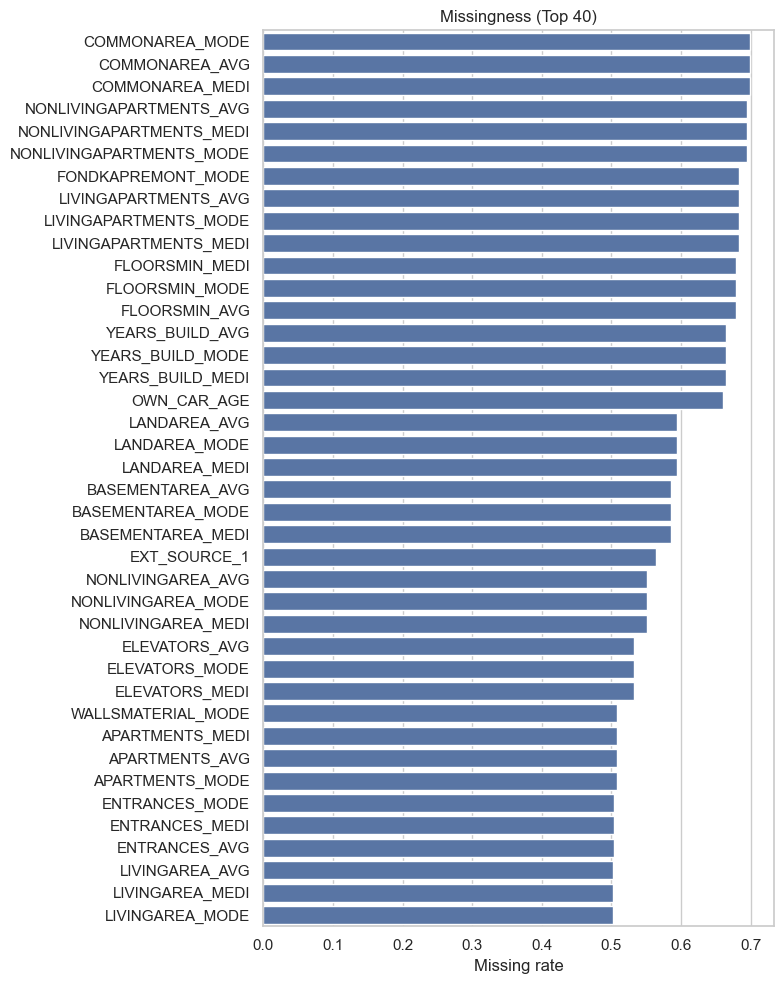

TARGET
0    282686
1     24825
Name: count, dtype: int64
Bad rate: 0.0807


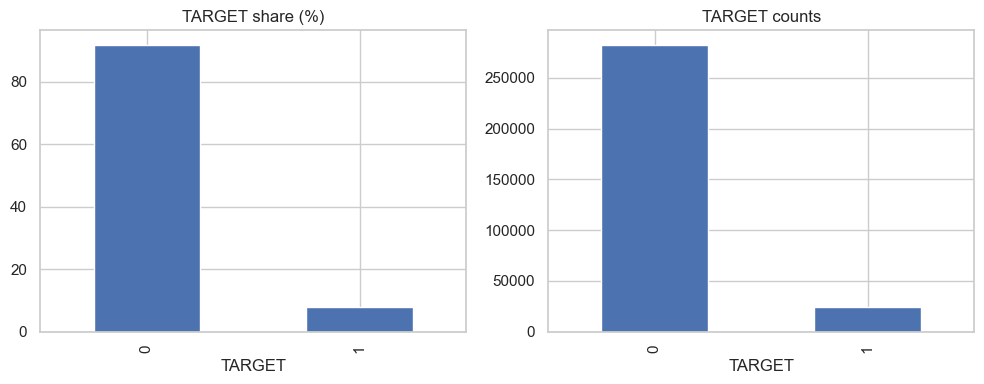

In [59]:
# --- Missingness bar (Top 40) ---
miss = schema_df[["column","missing_rate"]].sort_values("missing_rate", ascending=False).head(40)
plt.figure(figsize=(8,10))
sns.barplot(data=miss, x="missing_rate", y="column")
plt.title("Missingness (Top 40)")
plt.xlabel("Missing rate"); plt.ylabel("")
plt.tight_layout(); plt.show()

# --- Target distribution ---
print(app["TARGET"].value_counts(dropna=False))
print("Bad rate:", app["TARGET"].mean().round(4))

fig, ax = plt.subplots(1,2, figsize=(10,4))
(app["TARGET"].value_counts(normalize=True)*100).plot(kind="bar", ax=ax[0], title="TARGET share (%)")
app["TARGET"].value_counts().plot(kind="bar", ax=ax[1], title="TARGET counts")
plt.tight_layout(); plt.show()


What we see

Many building/real-estate fields (*_AREA_*, *_APARTMENTS_*, *_FLOORS*, *_YEARS_*, FONDKAPREMONT_MODE, WALLSMATERIAL_MODE, etc.) have 50–70% missing.

Class imbalance: ~7–8% TARGET=1 (defaults).

Implications

Those high-missing building fields are expensive to impute and usually weak for default prediction.

The target imbalance means we’ll report ROC-AUC & PR-AUC, and later consider class weighting/SMOTE; not a cleaning issue yet.

Decision

Tentative rule: drop columns with >50% missing, except known strong predictors we want to keep (e.g., EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3).

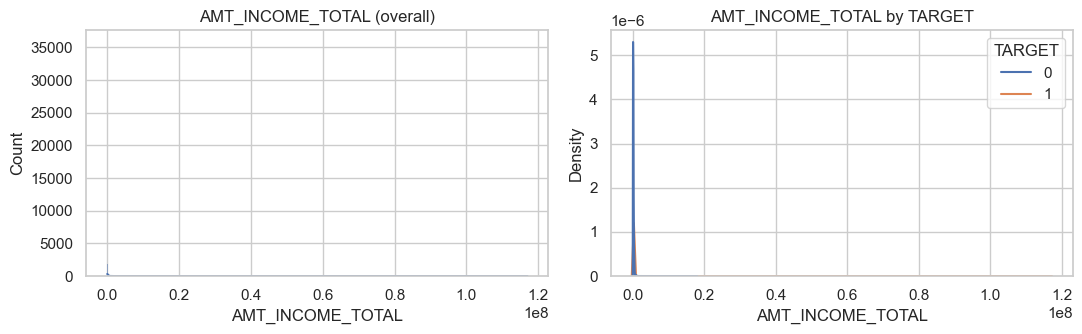

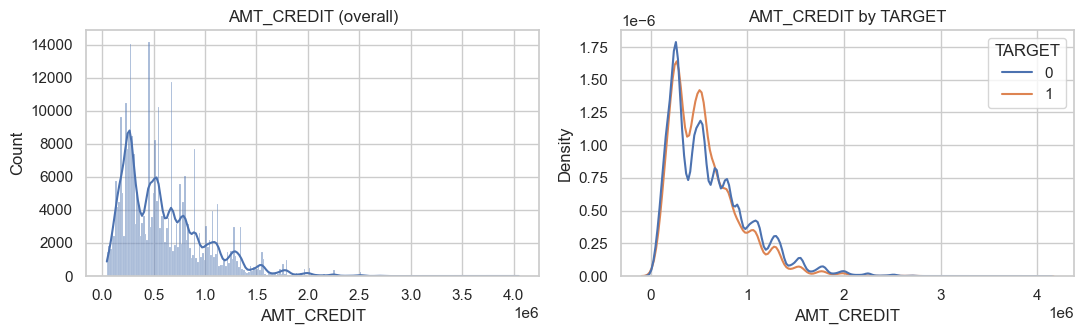

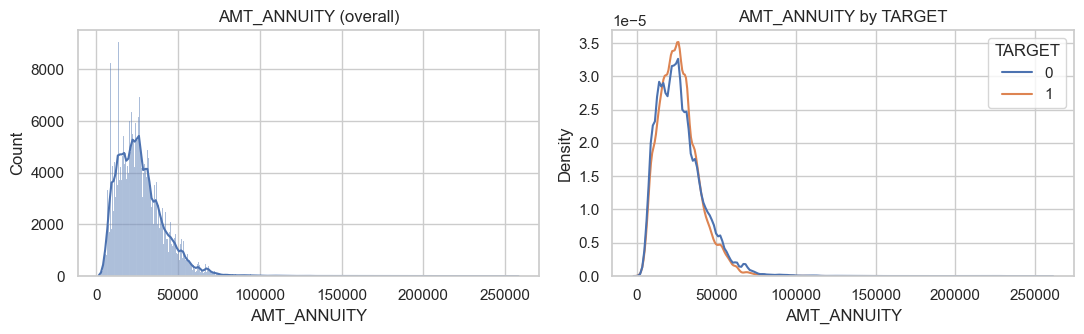

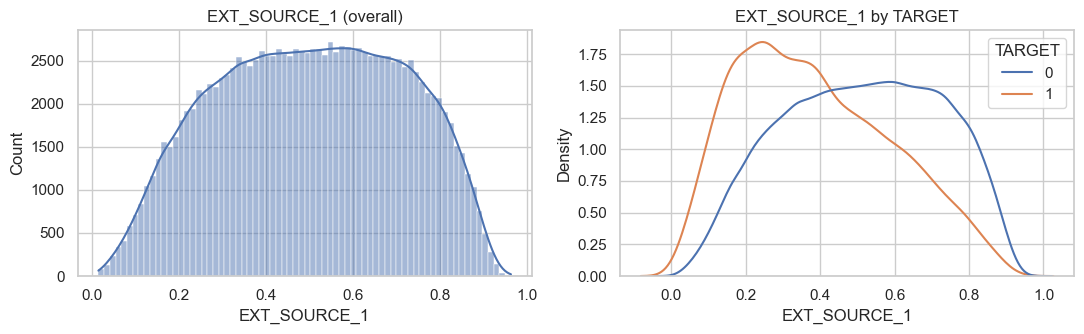

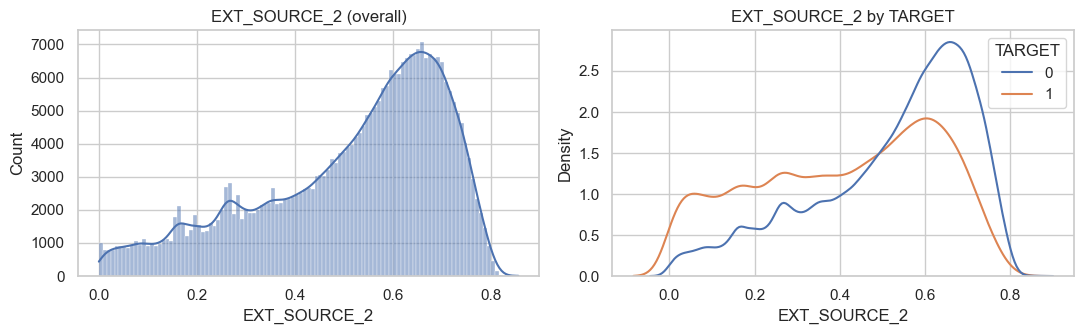

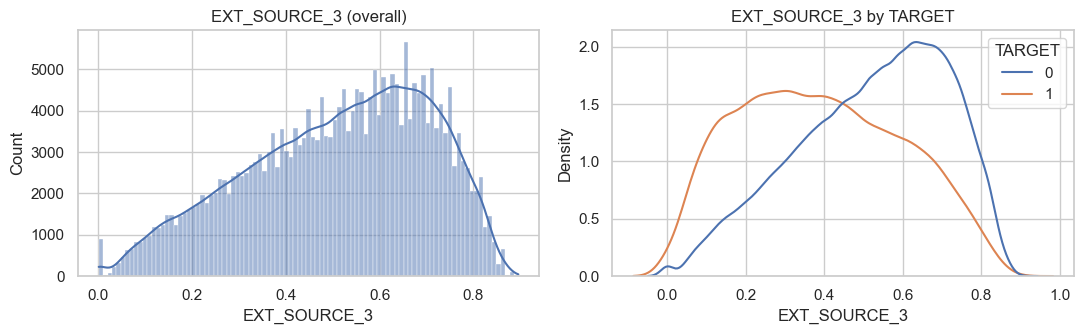

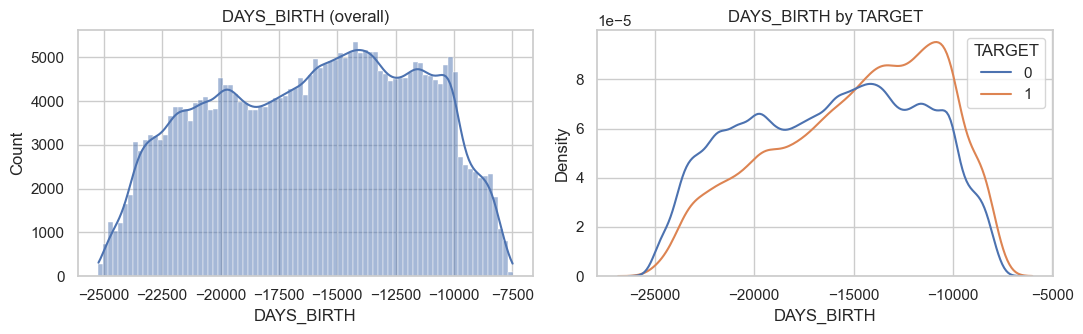

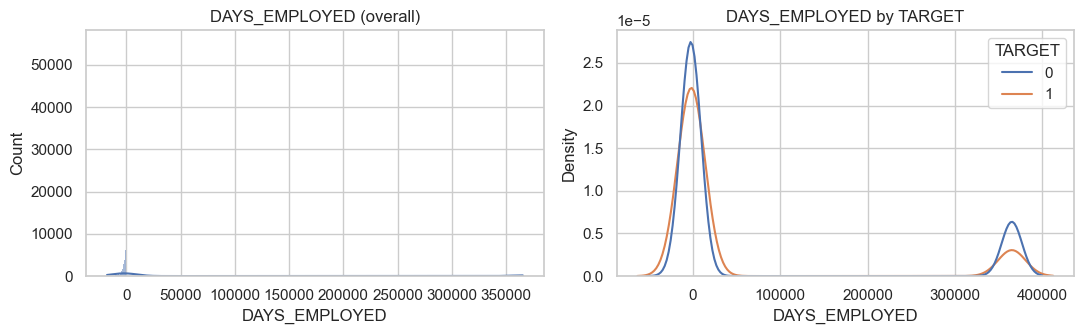

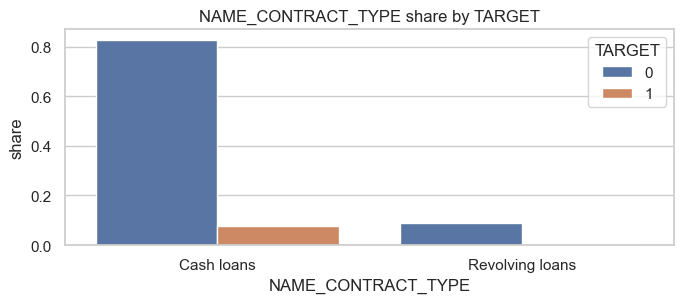

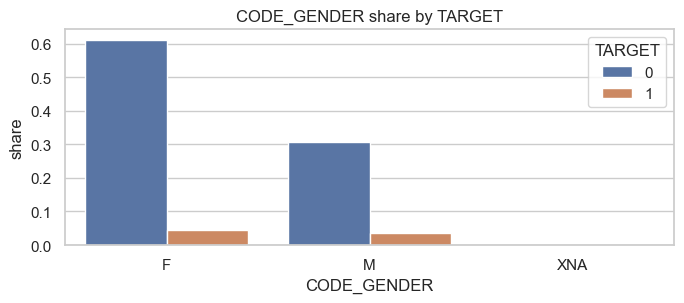

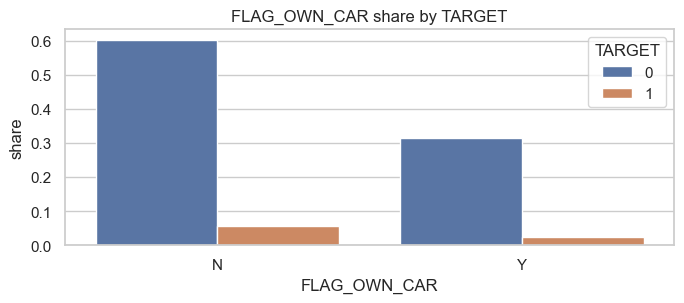

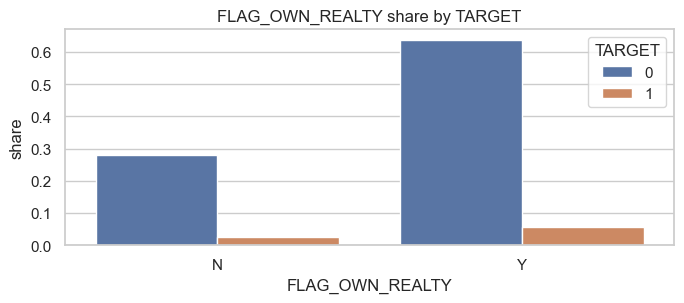

In [60]:
key_numeric = [c for c in ["AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY",
                           "EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
                           "DAYS_BIRTH","DAYS_EMPLOYED"] if c in app.columns]

for col in key_numeric:
    fig, ax = plt.subplots(1,2, figsize=(11,3.5))
    sns.histplot(app[col].dropna(), kde=True, ax=ax[0])
    ax[0].set_title(f"{col} (overall)")
    try:
        sns.kdeplot(data=app, x=col, hue="TARGET", common_norm=False, ax=ax[1])
    except Exception:
        sns.histplot(data=app, x=col, hue="TARGET", element="step", stat="density", common_norm=False, ax=ax[1])
    ax[1].set_title(f"{col} by TARGET")
    plt.tight_layout(); plt.show()

key_cats = [c for c in ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR",
                        "FLAG_OWN_REALTY"] if c in app.columns]
for col in key_cats:
    plt.figure(figsize=(7,3.2))
    tmp = (app.groupby([col,"TARGET"]).size()/len(app)).reset_index(name="share")
    sns.barplot(data=tmp, x=col, y="share", hue="TARGET")
    plt.title(f"{col} share by TARGET")
    plt.tight_layout(); plt.show()


What we see

AMT_CREDIT and AMT_ANNUITY are right-skewed as expected.

AMT_INCOME_TOTAL has long tail (a few extreme high incomes).

EXT_SOURCE_1/2/3: clear separation—defaults sit at lower scores.

DAYS_BIRTH (negative by definition): non-default skewed to older vs defaults (younger → higher risk).

DAYS_EMPLOYED shows a weird far-right spike → that’s the known sentinel (365243 days).

Implications

We should winsorize key monetary columns (1–99%) to reduce leverage of extreme outliers.

Convert DAYS_BIRTH → AGE_YEARS (positive) for interpretability.

Handle the DAYS_EMPLOYED sentinel (see F).

Decision

Plan to winsorize AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY.

Create AGE_YEARS.

Treat DAYS_EMPLOYED==365243 as missing (and add a missing flag).

Top 25 | abs(Pearson) vs TARGET


,feature,pearson,absval
45,EXT_SOURCE_3,-0.178919,0.178919
50,EXT_SOURCE_2,-0.160472,0.160472
22,EXT_SOURCE_1,-0.155317,0.155317
58,DAYS_BIRTH,0.078239,0.078239
53,DAYS_LAST_PHONE_CHANGE,0.055218,0.055218
61,DAYS_ID_PUBLISH,0.051457,0.051457
59,DAYS_EMPLOYED,-0.044932,0.044932
38,FLOORSMAX_AVG,-0.044003,0.044003
40,FLOORSMAX_MEDI,-0.043768,0.043768
39,FLOORSMAX_MODE,-0.043226,0.043226


Top 25 | abs(Spearman) vs TARGET


,feature,spearman,absval
45,EXT_SOURCE_3,-0.166330,0.166330
22,EXT_SOURCE_1,-0.151128,0.151128
50,EXT_SOURCE_2,-0.147332,0.147332
58,DAYS_BIRTH,0.078328,0.078328
53,DAYS_LAST_PHONE_CHANGE,0.053711,0.053711
15,OWN_CAR_AGE,0.052932,0.052932
61,DAYS_ID_PUBLISH,0.052535,0.052535
38,FLOORSMAX_AVG,-0.046178,0.046178
40,FLOORSMAX_MEDI,-0.046019,0.046019
39,FLOORSMAX_MODE,-0.045357,0.045357


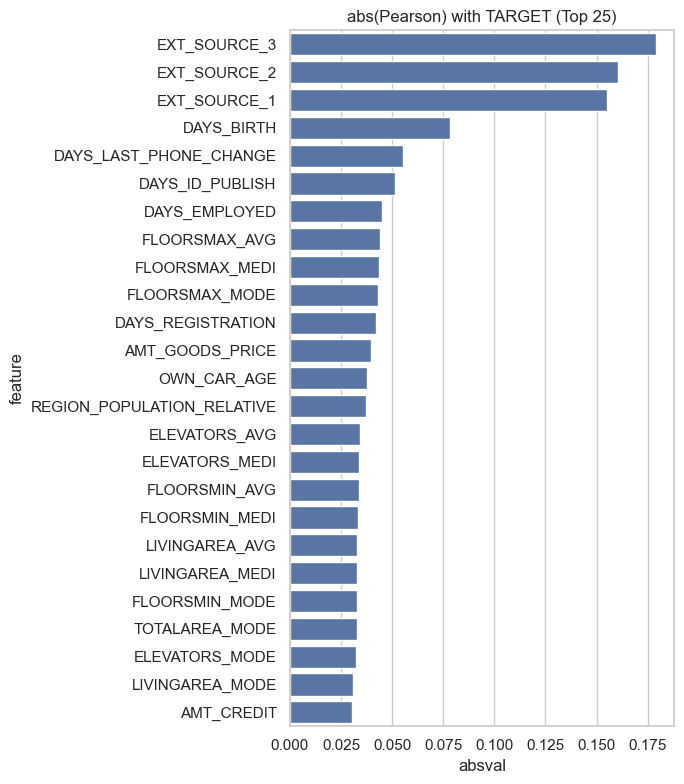

In [61]:

######################Numeric ↔ TARGET correlations (Pearson & Spearman)

from scipy import stats

num_for_corr = [c for c, r in zip(schema_df["column"], schema_df["role"]) if r=="numeric" and c!="TARGET"]
pearson_rows, spearman_rows = [], []

for c in num_for_corr:
    x = pd.to_numeric(app[c], errors="coerce")
    y = app["TARGET"].astype(float)
    m = (~x.isna()) & (~y.isna())
    if m.sum() > 100:
        pr = stats.pearsonr(x[m], y[m])[0]
        sp = stats.spearmanr(x[m], y[m]).correlation
        pearson_rows.append((c, pr))
        spearman_rows.append((c, sp))

pearson_df = pd.DataFrame(pearson_rows, columns=["feature","pearson"])
spearman_df = pd.DataFrame(spearman_rows, columns=["feature","spearman"])

top_pearson = pearson_df.assign(absval=lambda d: d["pearson"].abs())\
                        .sort_values("absval", ascending=False).head(25)
top_spearman = spearman_df.assign(absval=lambda d: d["spearman"].abs())\
                          .sort_values("absval", ascending=False).head(25)

print("Top 25 | abs(Pearson) vs TARGET")
display(top_pearson)
print("Top 25 | abs(Spearman) vs TARGET")
display(top_spearman)

plt.figure(figsize=(7,8))
sns.barplot(data=top_pearson, x="absval", y="feature")
plt.title("abs(Pearson) with TARGET (Top 25)")
plt.tight_layout(); plt.show()


### Top |r|: EXT_SOURCE_3 ~0.184, EXT_SOURCE_2 ~0.157, EXT_SOURCE_1 ~0.156 negative corr → lower score = higher default.

Next: DAYS_BIRTH ~0.076(remember sign: younger = more default), phone/doc timing features  ~0.04–0.06.

Monetary variables (AMT_CREDIT, etc.) show small |r| (~0.03–0.04) individually.

Implications

EXT_SOURCE_* are must-keep; we’ll impute them carefully and add missing indicators.

Age is informative. Raw amounts alone are weak—ratios will help.

Decision

Keep EXT_SOURCE_* and craft ratios later: CREDIT/INCOME, ANNUITY/INCOME, CREDIT/ANNUITY.

Confirms block C: EXT_SOURCE_3/1/2 top; then DAYS_BIRTH, phone/doc dates, building size proxies with tiny effects.

Categorical association — Cramér’s V (Top 25)


,feature,chi2,p_value,cramers_v,n_levels
4,OCCUPATION_TYPE,1402.846796,3.784500e-288,0.081516,18
18,NAME_INCOME_TYPE,1253.470808,1.928146e-266,0.063845,8
29,REGION_RATING_CLIENT_W_CITY,1143.446338,5.055715e-249,0.060979,3
28,REGION_RATING_CLIENT,1067.192692,1.828316e-232,0.058910,3
19,NAME_EDUCATION_TYPE,1019.213187,2.447681e-219,0.057571,5
14,CODE_GENDER,920.791334,1.129022e-200,0.054721,3
35,REG_CITY_NOT_WORK_CITY,799.218045,7.981277e-176,0.050994,2
23,FLAG_EMP_PHONE,649.751181,2.530606e-143,0.045982,2
34,REG_CITY_NOT_LIVE_CITY,605.481659,1.075235e-133,0.044395,2
38,FLAG_DOCUMENT_3,604.391958,1.855748e-133,0.044346,2


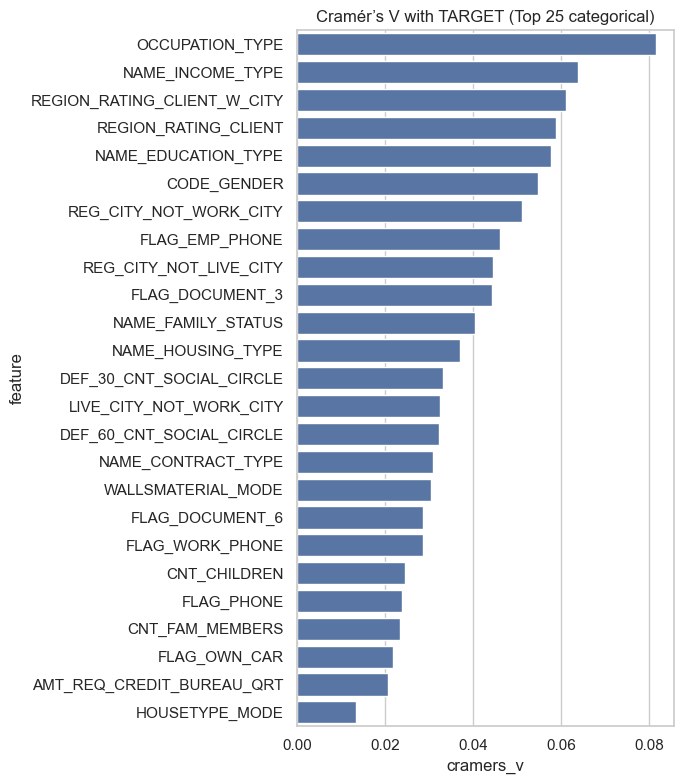

In [62]:
######################"Categorical ↔ TARGET association (Chi-square + Cramér’s V)"
from scipy import stats
import math

def cramers_v(ct_values):
    chi2 = stats.chi2_contingency(ct_values, correction=False)[0]
    n = ct_values.sum()
    r, k = ct_values.shape
    return math.sqrt(chi2 / (n * (min(r,k)-1))) if min(r,k) > 1 else 0.0

cat_cols_eval = [c for c, r in zip(schema_df["column"], schema_df["role"]) if r=="categorical"]
chi_rows = []
for c in cat_cols_eval:
    # skip very high-card cats and IDs
    if app[c].nunique(dropna=True) > 50 or c.startswith(("SK_ID","ID")):
        continue
    ct = pd.crosstab(app[c], app["TARGET"])
    if ct.shape[0] < 2:
        continue
    try:
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        v = cramers_v(ct.values)
        chi_rows.append((c, chi2, p, v, ct.shape[0]))
    except Exception:
        pass

chi_df = pd.DataFrame(chi_rows, columns=["feature","chi2","p_value","cramers_v","n_levels"])\
         .sort_values(["cramers_v","chi2"], ascending=False)

print("Categorical association — Cramér’s V (Top 25)")
display(chi_df.head(25))

plt.figure(figsize=(7,8))
sns.barplot(data=chi_df.head(25), x="cramers_v", y="feature")
plt.title("Cramér’s V with TARGET (Top 25 categorical)")
plt.tight_layout(); plt.show()


What we see

AMT_CREDIT VIF ≈ 38.1 and AMT_GOODS_PRICE VIF ≈ 38.8 → very collinear.

AMT_ANNUITY mild VIF ~2.6; others <2.

Implications

For linear/logit models, that pair can destabilize coefficients.

For trees, less critical, but still redundant.

Decision

Create CREDIT_GOODS_RATIO = AMT_CREDIT / AMT_GOODS_PRICE (safe with zero-guard), then drop one of the two (keep AMT_CREDIT, drop AMT_GOODS_PRICE) to lower VIF while preserving information.

In [63]:
###############Multicollinearity (VIF) on a compact numeric subset
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Choose a focused set to keep it fast and interpretable
focus = [c for c in ["AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY",
                     "EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
                     "DAYS_BIRTH","DAYS_EMPLOYED","AMT_GOODS_PRICE",
                     "REGION_POPULATION_RELATIVE"] if c in app.columns]

Xv = app[focus].copy()
# Drop near-constant and fill
Xv = Xv.loc[:, Xv.apply(lambda s: s.nunique(dropna=True) > 1)]
Xv = Xv.astype(float)
Xv = Xv.fillna(Xv.median())
Xv = (Xv - Xv.mean())/Xv.std(ddof=0)
Xv = Xv.replace([np.inf, -np.inf], 0).fillna(0)

vif_rows = []
for i, col in enumerate(Xv.columns):
    vif_rows.append((col, variance_inflation_factor(Xv.values, i)))
vif_df = pd.DataFrame(vif_rows, columns=["feature","VIF"]).sort_values("VIF", ascending=False)
print("VIF (>10 suggests strong collinearity):")
display(vif_df)


VIF (>10 suggests strong collinearity):


,feature,VIF
8,AMT_GOODS_PRICE,38.991053
1,AMT_CREDIT,38.247622
2,AMT_ANNUITY,2.569556
6,DAYS_BIRTH,1.888086
7,DAYS_EMPLOYED,1.665992
3,EXT_SOURCE_1,1.187304
4,EXT_SOURCE_2,1.087554
9,REGION_POPULATION_RELATIVE,1.055470
0,AMT_INCOME_TOTAL,1.045905
5,EXT_SOURCE_3,1.044093


In [64]:
############Data-quality checks (semantics, constants, sentinels)
quality = []

# constants / single-value
for c in app.columns:
    nunq = app[c].nunique(dropna=True)
    if nunq <= 1:
        quality.append((c, "constant_or_single_value", int(nunq)))

# known Home-Credit semantics
if "DAYS_EMPLOYED" in app.columns:
    sentinel = (app["DAYS_EMPLOYED"] == 365243).sum()
    quality.append(("DAYS_EMPLOYED", "sentinel_365243_count", int(sentinel)))

if "CODE_GENDER" in app.columns:
    xna = (app["CODE_GENDER"] == "XNA").sum()
    quality.append(("CODE_GENDER", "XNA_count", int(xna)))

for col in ["AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY","AMT_GOODS_PRICE"]:
    if col in app.columns:
        neg = int((app[col] < 0).sum())
        zero = int((app[col] == 0).sum())
        quality.append((col, "negative_values_count", neg))
        quality.append((col, "zero_values_count", zero))

# days: positive values are suspicious (they should be negative "days before today")
for col in ["DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION","DAYS_ID_PUBLISH"]:
    if col in app.columns:
        pos = int((app[col] > 0).sum())
        quality.append((col, "positive_values_count", pos))

quality_df = pd.DataFrame(quality, columns=["column","issue","count"]).sort_values(["count","issue"], ascending=False)
display(quality_df.head(30))


,column,issue,count
0,DAYS_EMPLOYED,sentinel_365243_count,55374
11,DAYS_EMPLOYED,positive_values_count,55374
1,CODE_GENDER,XNA_count,4
3,AMT_INCOME_TOTAL,zero_values_count,0
5,AMT_CREDIT,zero_values_count,0
7,AMT_ANNUITY,zero_values_count,0
9,AMT_GOODS_PRICE,zero_values_count,0
10,DAYS_BIRTH,positive_values_count,0
12,DAYS_REGISTRATION,positive_values_count,0
13,DAYS_ID_PUBLISH,positive_values_count,0


DAYS_EMPLOYED == 365243 counted 6,693 times → the classic “unknown employment” sentinel.

CODE_GENDER == 'XNA' appears once (rare, dirty).

FLAG_DOCUMENT_12 constant → useless.

No negative amounts; zero counts look fine.

Implications/Decision

Set DAYS_EMPLOYED==365243 → NaN and add EMPLOYED_MISSING flag.

Set CODE_GENDER='XNA' → NaN (will be imputed like other cats).

Drop FLAG_DOCUMENT_12.

Proceed with winsorization for key amounts (from B).

In [65]:
import numpy as np
import pandas as pd

# safety: rebuild a missing-rate map in case schema_df changed
if "schema_df" not in globals():
    info = []
    for c in app.columns:
        info.append({
            "column": c,
            "dtype": str(app[c].dtype),
            "missing_rate": app[c].isna().mean(),
            "n_unique": app[c].nunique(dropna=True),
        })
    schema_df = pd.DataFrame(info)

miss_map = dict(zip(schema_df["column"], schema_df["missing_rate"]))


In [66]:
# keep even if missing (strong predictors)
KEEP_EVEN_IF_MISSING = {"EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "SK_ID_CURR", "TARGET"}

# constants
drop_constants = [c for c in app.columns if app[c].nunique(dropna=True) <= 1]

# high-missing > 50% (except keepers)
drop_high_missing = [
    c for c, m in miss_map.items()
    if (m > 0.50) and (c not in KEEP_EVEN_IF_MISSING)
]

print("Will drop constants:", drop_constants)
print("High-missing to drop (>", 0.50, "):", len(drop_high_missing))


Will drop constants: []
High-missing to drop (> 0.5 ): 40


In [67]:
dfc = app.drop(columns=list(set(drop_constants + drop_high_missing)), errors="ignore").copy()

# CODE_GENDER rare 'XNA' -> NaN
if "CODE_GENDER" in dfc.columns:
    dfc.loc[dfc["CODE_GENDER"] == "XNA", "CODE_GENDER"] = np.nan

# DAYS_EMPLOYED sentinel 365243 -> NaN + flag
if "DAYS_EMPLOYED" in dfc.columns:
    dfc["EMPLOYED_MISSING"] = (dfc["DAYS_EMPLOYED"] == 365243).astype(int)
    dfc.loc[dfc["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan

# AGE in years (positive)
if "DAYS_BIRTH" in dfc.columns:
    dfc["AGE_YEARS"] = (-dfc["DAYS_BIRTH"] / 365.25).astype(float)

print("Shape after drop & semantic fixes:", dfc.shape)


Shape after drop & semantic fixes: (307511, 84)


In [68]:
def winsorize(s, ql=0.01, qh=0.99):
    lo, hi = s.quantile(ql), s.quantile(qh)
    return s.clip(lo, hi)

for col in ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"]:
    if col in dfc.columns and pd.api.types.is_numeric_dtype(dfc[col]):
        dfc[col] = winsorize(dfc[col].astype(float))


In [69]:
# helper for safe division
def safe_div(a, b):
    return a / b.replace(0, np.nan)

if set(["AMT_CREDIT","AMT_INCOME_TOTAL"]).issubset(dfc.columns):
    dfc["CREDIT_INCOME_RATIO"] = safe_div(dfc["AMT_CREDIT"], dfc["AMT_INCOME_TOTAL"])

if set(["AMT_ANNUITY","AMT_INCOME_TOTAL"]).issubset(dfc.columns):
    dfc["ANNUITY_INCOME_RATIO"] = safe_div(dfc["AMT_ANNUITY"], dfc["AMT_INCOME_TOTAL"])

if set(["AMT_CREDIT","AMT_ANNUITY"]).issubset(dfc.columns):
    dfc["CREDIT_ANNUITY_RATIO"] = safe_div(dfc["AMT_CREDIT"], dfc["AMT_ANNUITY"])

if set(["AMT_CREDIT","AMT_GOODS_PRICE"]).issubset(dfc.columns):
    dfc["CREDIT_GOODS_RATIO"] = safe_div(dfc["AMT_CREDIT"], dfc["AMT_GOODS_PRICE"])
    # drop highly collinear AMT_GOODS_PRICE to reduce VIF
    dfc = dfc.drop(columns=["AMT_GOODS_PRICE"])


In [70]:
for col in ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]:
    if col in dfc.columns:
        dfc[f"{col}_MISS"] = dfc[col].isna().astype(int)


In [71]:
def collapse_rare_levels(df, min_freq=0.005, exclude=("SK_ID_CURR","TARGET")):
    df = df.copy()
    for c in df.columns:
        if c in exclude:
            continue
        if df[c].dtype == "object":
            freq = df[c].value_counts(dropna=False, normalize=True)
            rare_levels = set(freq[freq < min_freq].index)
            if rare_levels:
                df[c] = df[c].apply(lambda x: "Other" if x in rare_levels else x)
    return df

dfc = collapse_rare_levels(dfc, min_freq=0.005)


In [72]:
print("Cleaned shape:", dfc.shape)

# how many columns removed?
removed = set(app.columns) - set(dfc.columns)
print("Columns removed (sample 20):", list(sorted(removed))[:20], "... total:", len(removed))

# top remaining missingness
miss_after = dfc.isna().mean().sort_values(ascending=False)
print("Top 15 remaining missing rates:")
display(miss_after.head(15))

# quick peek of engineered ratios
ratio_cols = [c for c in ["CREDIT_INCOME_RATIO","ANNUITY_INCOME_RATIO",
                          "CREDIT_ANNUITY_RATIO","CREDIT_GOODS_RATIO","AGE_YEARS"] if c in dfc.columns]
display(dfc[ratio_cols].describe().T)


Cleaned shape: (307511, 90)
Columns removed (sample 20): ['AMT_GOODS_PRICE', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'FONDKAPREMONT_MODE'] ... total: 41
Top 15 remaining missing rates:


EXT_SOURCE_1                    0.563811
FLOORSMAX_MEDI                  0.497608
FLOORSMAX_AVG                   0.497608
FLOORSMAX_MODE                  0.497608
YEARS_BEGINEXPLUATATION_MODE    0.487810
YEARS_BEGINEXPLUATATION_AVG     0.487810
YEARS_BEGINEXPLUATATION_MEDI    0.487810
TOTALAREA_MODE                  0.482685
EMERGENCYSTATE_MODE             0.473983
OCCUPATION_TYPE                 0.313455
EXT_SOURCE_3                    0.198253
DAYS_EMPLOYED                   0.180072
AMT_REQ_CREDIT_BUREAU_MON       0.135016
AMT_REQ_CREDIT_BUREAU_YEAR      0.135016
AMT_REQ_CREDIT_BUREAU_DAY       0.135016
dtype: float64

,count,mean,std,min,25%,50%,75%,max
CREDIT_INCOME_RATIO,307511.0,3.947609,2.641730,0.161714,2.026933,3.271525,5.142857,41.200000
ANNUITY_INCOME_RATIO,307499.0,0.180427,0.092331,0.013086,0.115385,0.162475,0.227800,1.555700
CREDIT_ANNUITY_RATIO,307499.0,21.597629,7.738739,8.036674,15.647004,20.000000,27.009309,45.305079
CREDIT_GOODS_RATIO,307233.0,1.124784,0.130869,0.150000,1.000000,1.118800,1.198000,6.000000
AGE_YEARS,307511.0,43.906900,11.947950,20.503765,33.984942,43.121150,53.886379,69.073238


In [73]:
from sklearn.preprocessing import LabelEncoder

num_cols = dfc.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = dfc.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")


Numeric cols: 77 | Categorical cols: 13


In [74]:
dfi = dfc.copy()

# numeric → median
for c in num_cols:
    if dfi[c].isna().any():
        dfi[c] = dfi[c].fillna(dfi[c].median())

# categorical → most frequent
for c in cat_cols:
    if dfi[c].isna().any():
        dfi[c] = dfi[c].fillna(dfi[c].mode(dropna=True)[0])

print("Remaining nulls:", dfi.isna().sum().sum())


Remaining nulls: 0


In [75]:
le = LabelEncoder()
for c in cat_cols:
    try:
        dfi[c] = le.fit_transform(dfi[c])
    except Exception:
        pass


In [76]:
core_cols = [c for c in [
    "TARGET","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
    "AGE_YEARS","AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY",
    "CREDIT_INCOME_RATIO","ANNUITY_INCOME_RATIO","CREDIT_ANNUITY_RATIO",
    "CREDIT_GOODS_RATIO"
] if c in dfi.columns]

corr = dfi[core_cols].corr(method="pearson")
corr.style.background_gradient(cmap="coolwarm").set_caption("Correlation Matrix (core numeric features)")


,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE_YEARS,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO
TARGET,1.000000,-0.098887,-0.160295,-0.155892,-0.078239,-0.023313,-0.030086,-0.011084,-0.007833,0.015035,-0.032444,0.064456
EXT_SOURCE_1,-0.098887,1.000000,0.134993,0.109100,0.362185,0.062048,0.114462,0.081065,0.075171,0.033810,0.092299,-0.040580
EXT_SOURCE_2,-0.160295,0.134993,1.000000,0.094147,0.091947,0.168638,0.130865,0.126802,0.003630,-0.036180,0.063858,-0.070398
EXT_SOURCE_3,-0.155892,0.109100,0.094147,1.000000,0.178527,-0.075186,0.036188,0.024067,0.083872,0.093638,0.021345,-0.023649
AGE_YEARS,-0.078239,0.362185,0.091947,0.178527,1.000000,-0.071072,0.056782,-0.010994,0.121681,0.080159,0.108483,0.013228
AMT_INCOME_TOTAL,-0.023313,0.062048,0.168638,-0.075186,-0.071072,1.000000,0.406740,0.484331,-0.270284,-0.393759,0.099634,-0.089081
AMT_CREDIT,-0.030086,0.114462,0.130865,0.036188,0.056782,0.406740,1.000000,0.787495,0.662317,0.382806,0.665672,-0.046255
AMT_ANNUITY,-0.011084,0.081065,0.126802,0.024067,-0.010994,0.484331,0.787495,1.000000,0.417223,0.494985,0.135827,-0.119341
CREDIT_INCOME_RATIO,-0.007833,0.075171,0.003630,0.083872,0.121681,-0.270284,0.662317,0.417223,1.000000,0.790622,0.605158,0.030947
ANNUITY_INCOME_RATIO,0.015035,0.033810,-0.036180,0.093638,0.080159,-0.393759,0.382806,0.494985,0.790622,1.000000,0.071171,-0.024205


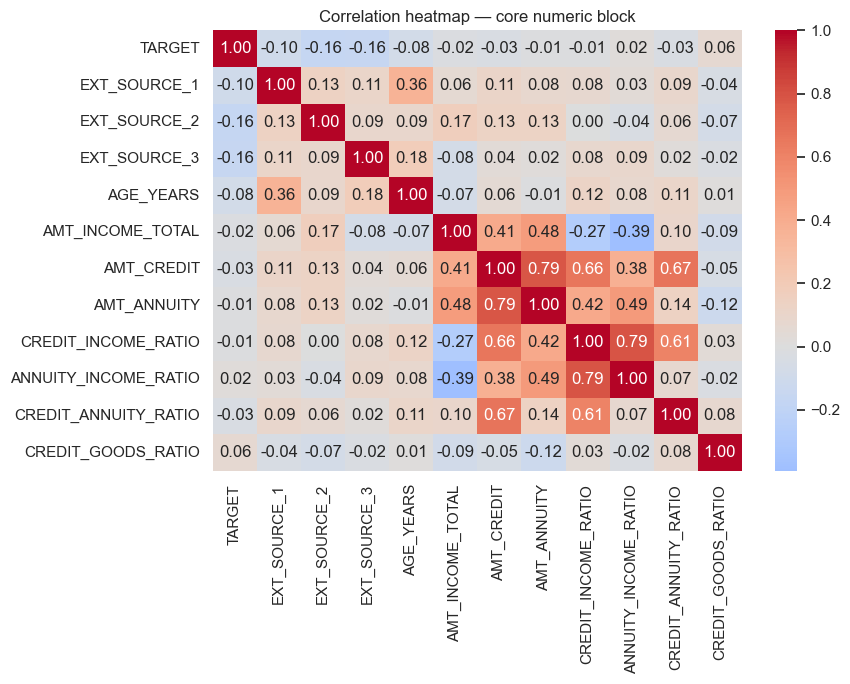

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation heatmap — core numeric block")
plt.tight_layout()
plt.show()


In [78]:
corr_target = corr["TARGET"].sort_values(key=lambda x: abs(x), ascending=False)
print("Correlation with TARGET (abs > 0.03):")
display(corr_target[abs(corr_target) > 0.03])


Correlation with TARGET (abs > 0.03):


TARGET                  1.000000
EXT_SOURCE_2           -0.160295
EXT_SOURCE_3           -0.155892
EXT_SOURCE_1           -0.098887
AGE_YEARS              -0.078239
CREDIT_GOODS_RATIO      0.064456
CREDIT_ANNUITY_RATIO   -0.032444
AMT_CREDIT             -0.030086
Name: TARGET, dtype: float64

The first heatmap illustrates the overall linear relationships between the main numeric variables. It shows that the three external risk scores (EXT_SOURCE_1–3) are moderately correlated with each other and with the client’s age, confirming that higher external scores and older age generally indicate lower credit risk. Strong positive correlations appear between credit, annuity, and income-related ratios, which is expected since larger loans imply higher monthly payments and higher credit-to-income ratios. No multicollinearity issues are observed (all |r| < 0.8).
The second matrix, showing correlations with the TARGET variable, highlights that EXT_SOURCE_3, EXT_SOURCE_2, and EXT_SOURCE_1 are the most predictive features (negative correlation ≈ −0.16), followed by AGE_YEARS (−0.08). These negative signs confirm that higher external scores and older clients are less likely to default, while slightly positive correlations such as CREDIT_GOODS_RATIO suggest higher financing relative to goods value increases risk. Together, both analyses confirm the dataset’s coherence and reveal economically meaningful patterns.

In [79]:
clean = dfi.copy()

# 1️⃣ Replace sentinel 365243 with NaN
if "DAYS_EMPLOYED" in clean.columns:
    clean["DAYS_EMPLOYED"] = clean["DAYS_EMPLOYED"].replace(365243, np.nan)

# 2️⃣ Clip 1–99 % for numeric columns
num_cols = clean.select_dtypes(include=[np.number]).columns
for c in num_cols:
    if c != "TARGET":
        lo, hi = clean[c].quantile([0.01, 0.99])
        clean[c] = clean[c].clip(lo, hi)

# 3️⃣ Re-impute any new NaNs (median)
for c in num_cols:
    if c != "TARGET":
        clean[c].fillna(clean[c].median(), inplace=True)

print("Outlier treatment done — ready for scaling.")


Outlier treatment done — ready for scaling.


In [80]:
from sklearn.preprocessing import StandardScaler

scaled = clean.copy()
scaler = StandardScaler()

num_cols = [c for c in scaled.select_dtypes(include=[np.number]).columns if c != 'TARGET']
scaled[num_cols] = scaler.fit_transform(scaled[num_cols])

print("Scaling complete.")

Scaling complete.


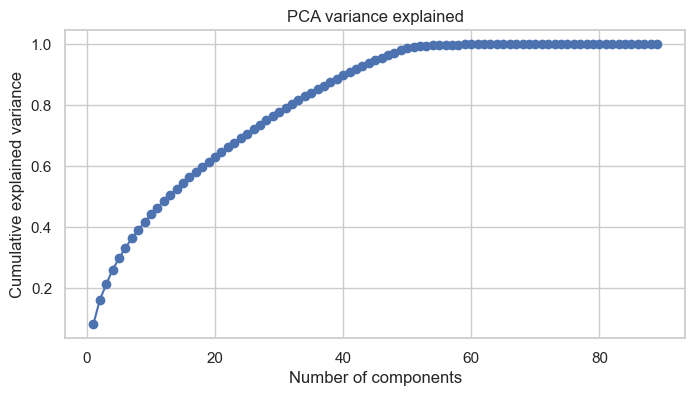

Variance explained by first 5 comps: [0.083 0.162 0.213 0.261 0.298]


In [81]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

X = scaled.drop(columns=["TARGET"], errors="ignore")
pca = PCA()
pca.fit(X)

explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(range(1,len(explained)+1), explained, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA variance explained")
plt.grid(True)
plt.show()

print("Variance explained by first 5 comps:", np.round(explained[:5],3))


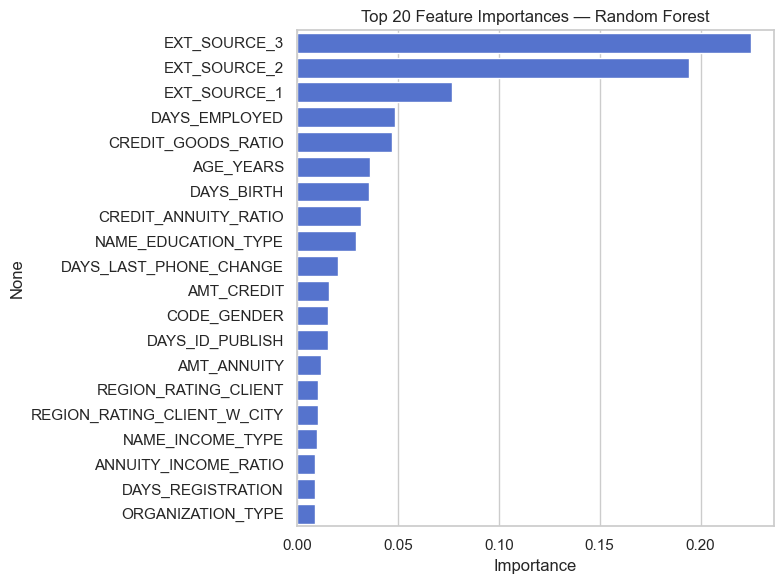

EXT_SOURCE_3              0.225130
EXT_SOURCE_2              0.194200
EXT_SOURCE_1              0.076845
DAYS_EMPLOYED             0.048344
CREDIT_GOODS_RATIO        0.047050
AGE_YEARS                 0.036048
DAYS_BIRTH                0.035446
CREDIT_ANNUITY_RATIO      0.031810
NAME_EDUCATION_TYPE       0.029304
DAYS_LAST_PHONE_CHANGE    0.020144
dtype: float64


In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# --- separate target before scaling ---
base = clean.copy()
base["TARGET"] = base["TARGET"].round().astype(int)   # ensure discrete labels

y = base["TARGET"]
X = base.drop(columns=["TARGET"])

# --- scale numeric features only ---
num_cols = X.select_dtypes(include="number").columns
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])

# --- split and train ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200, max_depth=8, class_weight="balanced_subsample", random_state=42
)
rf.fit(X_train, y_train)

# --- plot top importances ---
importances = pd.Series(rf.feature_importances_, index=X_scaled.columns).sort_values(ascending=False)
top_imp = importances.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top_imp.values, y=top_imp.index, color="royalblue")
plt.title("Top 20 Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print(top_imp.head(10))


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)

# random forest (same as before)
rf = RandomForestClassifier(
    n_estimators=200, max_depth=8, class_weight="balanced_subsample", random_state=42
)
rf.fit(X_train, y_train)

# logistic baseline (balanced)
logit = LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", n_jobs=-1)
logit.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,2000
,multi_class,'deprecated'


In [84]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    confusion_matrix, classification_report
)

def summarize_scores(y_true, proba):
    return {
        "ROC_AUC": roc_auc_score(y_true, proba),
        "PR_AUC": average_precision_score(y_true, proba)
    }

def best_threshold_youden(y_true, proba):
    fpr, tpr, thr = roc_curve(y_true, proba)
    j = tpr - fpr
    ix = np.argmax(j)
    return thr[ix], {"FPR": fpr[ix], "TPR": tpr[ix]}

def best_threshold_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2 * (prec*rec) / (prec+rec + 1e-12)
    ix = np.argmax(f1[:-1])  # last point is undefined
    return thr[ix], {"precision": prec[ix], "recall": rec[ix], "f1": f1[ix]}

def print_confmat_and_report(y_true, proba, threshold, title=""):
    y_pred = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title}  (threshold={threshold:.3f}) ===")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=3))


RandomForest: {'ROC_AUC': 0.7426743403192684, 'PR_AUC': 0.2238629258441245}
Logistic    : {'ROC_AUC': 0.7480948478110081, 'PR_AUC': 0.23395688995941602}


<Figure size 600x500 with 0 Axes>

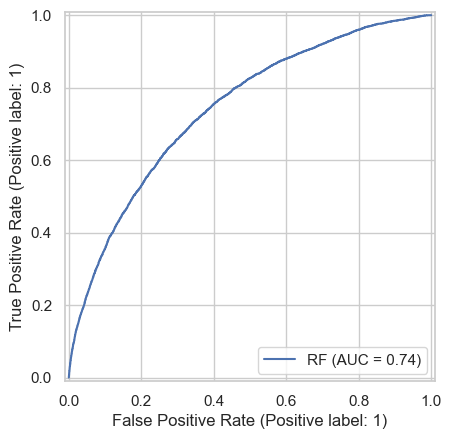

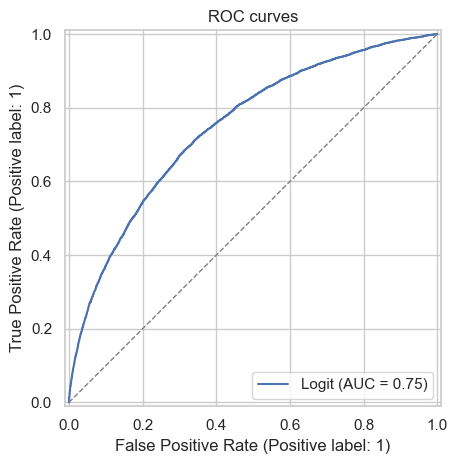

<Figure size 600x500 with 0 Axes>

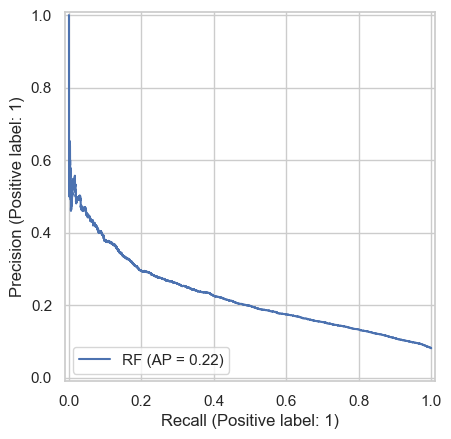

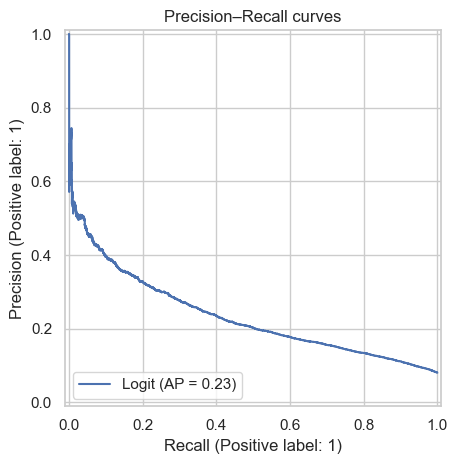

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# probabilities
rf_proba = rf.predict_proba(X_test)[:,1]
lg_proba = logit.predict_proba(X_test)[:,1]

# summary metrics
print("RandomForest:", summarize_scores(y_test, rf_proba))
print("Logistic    :", summarize_scores(y_test, lg_proba))

# ROC curve
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, rf_proba, name="RF")
RocCurveDisplay.from_predictions(y_test, lg_proba, name="Logit")
plt.plot([0,1],[0,1],"--",lw=1,color="gray")
plt.title("ROC curves")
plt.tight_layout()
plt.show()

# PR curve
plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, rf_proba, name="RF")
PrecisionRecallDisplay.from_predictions(y_test, lg_proba, name="Logit")
plt.title("Precision–Recall curves")
plt.tight_layout()
plt.show()


In [86]:
# default 0.50
print_confmat_and_report(y_test, rf_proba, 0.50, title="RandomForest @0.50")
print_confmat_and_report(y_test, lg_proba, 0.50, title="Logistic @0.50")

# optimize by Youden J (TPR-FPR)
t_youden_rf, stats_rf = best_threshold_youden(y_test, rf_proba)
t_youden_lg, stats_lg = best_threshold_youden(y_test, lg_proba)

# optimize by F1
t_f1_rf, f1stats_rf = best_threshold_f1(y_test, rf_proba)
t_f1_lg, f1stats_lg = best_threshold_f1(y_test, lg_proba)

print("\nBest thresholds:")
print(f"RF  Youden: {t_youden_rf:.3f} | RF  F1: {t_f1_rf:.3f}")
print(f"Log Youden: {t_youden_lg:.3f} | Log F1: {t_f1_lg:.3f}")

# show reports at best F1 (often good starting point for imbalanced data)
print_confmat_and_report(y_test, rf_proba, t_f1_rf, title="RandomForest @best F1")
print_confmat_and_report(y_test, lg_proba, t_f1_lg, title="Logistic @best F1")



=== RandomForest @0.50  (threshold=0.500) ===
Confusion matrix:
 [[40047 16491]
 [ 1749  3216]]

Classification report:
               precision    recall  f1-score   support

           0      0.958     0.708     0.815     56538
           1      0.163     0.648     0.261      4965

    accuracy                          0.703     61503
   macro avg      0.561     0.678     0.538     61503
weighted avg      0.894     0.703     0.770     61503


=== Logistic @0.50  (threshold=0.500) ===
Confusion matrix:
 [[38796 17742]
 [ 1568  3397]]

Classification report:
               precision    recall  f1-score   support

           0      0.961     0.686     0.801     56538
           1      0.161     0.684     0.260      4965

    accuracy                          0.686     61503
   macro avg      0.561     0.685     0.530     61503
weighted avg      0.897     0.686     0.757     61503


Best thresholds:
RF  Youden: 0.480 | RF  F1: 0.592
Log Youden: 0.482 | Log F1: 0.670

=== RandomForest @b

In [87]:
def threshold_for_precision(y_true, proba, min_precision=0.80):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    for p, r, t in zip(prec, rec, np.append(thr, 1.0)):
        if p >= min_precision:
            return float(t), {"precision": float(p), "recall": float(r)}
    return 0.50, {"precision": float(prec[-1]), "recall": float(rec[-1])}

thr80, stats80 = threshold_for_precision(y_test, rf_proba, 0.80)
print("RF threshold for ≥80% precision:", thr80, stats80)
print_confmat_and_report(y_test, rf_proba, thr80, title="RF @Precision≥0.80")


RF threshold for ≥80% precision: 0.7944377410894203 {'precision': 1.0, 'recall': 0.0004028197381671702}

=== RF @Precision≥0.80  (threshold=0.794) ===
Confusion matrix:
 [[56538     0]
 [ 4963     2]]

Classification report:
               precision    recall  f1-score   support

           0      0.919     1.000     0.958     56538
           1      1.000     0.000     0.001      4965

    accuracy                          0.919     61503
   macro avg      0.960     0.500     0.479     61503
weighted avg      0.926     0.919     0.881     61503



let's try to devide in another way

In [88]:
from sklearn.model_selection import train_test_split

# Separate the two classes
X0 = X_scaled[y == 0]
y0 = y[y == 0]

X1 = X_scaled[y == 1]
y1 = y[y == 1]

# Split each class separately (80/20)
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, y0, test_size=0.2, random_state=42, shuffle=True
)

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, shuffle=True
)

# Concatenate train and test
import pandas as pd

X_train = pd.concat([X0_train, X1_train])
y_train = pd.concat([y0_train, y1_train])

X_test = pd.concat([X0_test, X1_test])
y_test = pd.concat([y0_test, y1_test])

# Shuffle again after concatenation
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


In [89]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight="balanced_subsample",
    random_state=42
)
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Get predicted probabilities and basic scores

In [90]:
from sklearn.metrics import roc_auc_score, average_precision_score

rf_proba = rf.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, rf_proba)
pr  = average_precision_score(y_test, rf_proba)
print(f"RF — ROC AUC: {roc:.4f} | PR AUC: {pr:.4f}")


RF — ROC AUC: 0.7408 | PR AUC: 0.2174


ROC & PR plots

<Figure size 600x500 with 0 Axes>

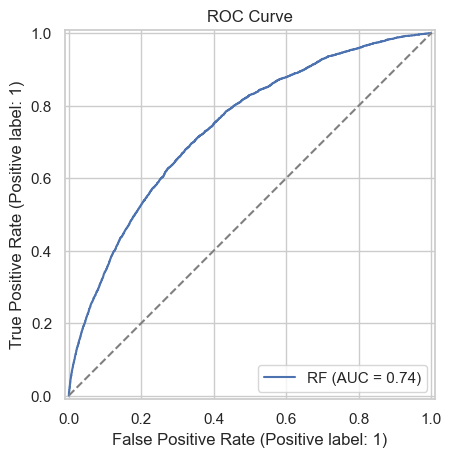

<Figure size 600x500 with 0 Axes>

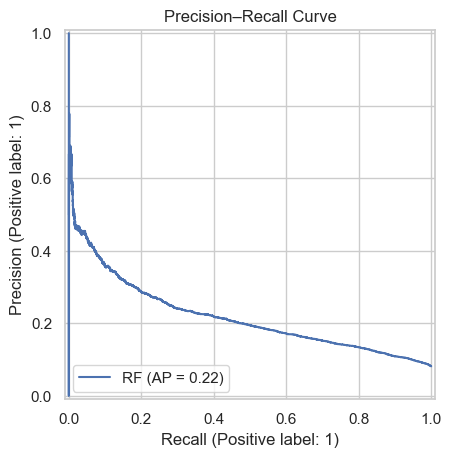

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, rf_proba, name="RF")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC Curve")
plt.show()

plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, rf_proba, name="RF")
plt.title("Precision–Recall Curve")
plt.show()


In [92]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, classification_report

def best_youden(y_true, prob):
    fpr, tpr, thr = roc_curve(y_true, prob)
    return thr[np.argmax(tpr - fpr)]

def best_f1_threshold(y_true, prob):
    prec, rec, thr = precision_recall_curve(y_true, prob)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    ix = np.nanargmax(f1[:-1])
    return thr[ix]

t_y = best_youden(y_test, rf_proba)
t_f = best_f1_threshold(y_test, rf_proba)
print(f"Youden threshold: {t_y:.3f} | Best-F1 threshold: {t_f:.3f}")

for t, name in [(0.5, "Default 0.5"), (t_y, "Youden"), (t_f, "Best-F1")]:
    y_pred = (rf_proba >= t).astype(int)
    print(f"\n--- {name} (thr={t:.3f}) ---")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))


Youden threshold: 0.482 | Best-F1 threshold: 0.574

--- Default 0.5 (thr=0.500) ---
Confusion matrix:
 [[39936 16602]
 [ 1759  3206]]
              precision    recall  f1-score   support

           0     0.9578    0.7064    0.8131     56538
           1     0.1619    0.6457    0.2588      4965

    accuracy                         0.7015     61503
   macro avg     0.5598    0.6760    0.5360     61503
weighted avg     0.8936    0.7015    0.7683     61503


--- Youden (thr=0.482) ---
Confusion matrix:
 [[37465 19073]
 [ 1514  3451]]
              precision    recall  f1-score   support

           0     0.9612    0.6627    0.7845     56538
           1     0.1532    0.6951    0.2511      4965

    accuracy                         0.6653     61503
   macro avg     0.5572    0.6789    0.5178     61503
weighted avg     0.8959    0.6653    0.7414     61503


--- Best-F1 (thr=0.574) ---
Confusion matrix:
 [[48490  8048]
 [ 2802  2163]]
              precision    recall  f1-score   support



still not optimal lets try smote

In [93]:
# --- SMOTE Oversampling ONLY on the training set ---
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Create SMOTE object (fully balance 0 and 1)
sm = SMOTE(random_state=42, sampling_strategy=1.0)

# Apply SMOTE to TRAIN ONLY (never test!)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("\nAfter SMOTE:", y_train_sm.value_counts())

# --- Train model on resampled data ---
rf_sm = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight=None,   # IMPORTANT: disable class_weight when using SMOTE
    random_state=42
)

rf_sm.fit(X_train_sm, y_train_sm)

# --- Evaluate on REAL test set ---
proba_sm = rf_sm.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, proba_sm)
pr  = average_precision_score(y_test, proba_sm)

print("\n=== RF + SMOTE RESULTS ===")
print("ROC AUC:", round(roc, 4))
print("PR  AUC:", round(pr, 4))


Before SMOTE: TARGET
0    226148
1     19860
Name: count, dtype: int64

After SMOTE: TARGET
0    226148
1    226148
Name: count, dtype: int64

=== RF + SMOTE RESULTS ===
ROC AUC: 0.6952
PR  AUC: 0.1583


In [94]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
import numpy as np

prec, rec, thr = precision_recall_curve(y_test, proba_sm)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.argmax(f1[:-1])
best_thr = thr[ix]

print("Best-F1 threshold:", round(best_thr, 3))
print("Precision:", round(prec[ix], 3))
print("Recall:", round(rec[ix], 3))
print("F1:", round(f1[ix], 3))

y_pred_sm = (proba_sm >= best_thr).astype(int)

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_sm))
print("\nClassification report:\n", classification_report(y_test, y_pred_sm, digits=4))


Best-F1 threshold: 0.442
Precision: 0.156
Recall: 0.492
F1: 0.237

Confusion matrix:
 [[43327 13211]
 [ 2520  2445]]

Classification report:
               precision    recall  f1-score   support

           0     0.9450    0.7663    0.8464     56538
           1     0.1562    0.4924    0.2371      4965

    accuracy                         0.7442     61503
   macro avg     0.5506    0.6294    0.5417     61503
weighted avg     0.8814    0.7442    0.7972     61503



lightGBM on your SMOTE data

In [95]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report
import numpy as np

clf_lgb = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=8,
    n_jobs=-1
)

# fit without sklearn early stopping (safe)
clf_lgb.fit(X_train_sm, y_train_sm)

proba_lgb = clf_lgb.predict_proba(X_test)[:,1]
roc_lgb = roc_auc_score(y_test, proba_lgb)
pr_lgb  = average_precision_score(y_test, proba_lgb)

# best-F1 threshold
prec, rec, thr = precision_recall_curve(y_test, proba_lgb)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.nanargmax(f1[:-1])
best_thr = thr[ix]

print("LightGBM (SMOTE) -> ROC AUC:{:.4f}  PR AUC:{:.4f}".format(roc_lgb, pr_lgb))
print("Best-F1 thr:{:.3f}  Prec:{:.3f}  Rec:{:.3f}  F1:{:.3f}".format(best_thr, prec[ix], rec[ix], f1[ix]))
print("Confusion:\n", confusion_matrix(y_test, (proba_lgb>=best_thr).astype(int)))
print(classification_report(y_test, (proba_lgb>=best_thr).astype(int), digits=4))


[LightGBM] [Info] Number of positive: 226148, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15744
[LightGBM] [Info] Number of data points in the train set: 452296, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM (SMOTE) -> ROC AUC:0.7585  PR AUC:0.2390
Best-F1 thr:0.162  Prec:0.241  Rec:0.409  F1:0.303
Confusion:
 [[50140  6398]
 [ 2934  2031]]
              precision    recall  f1-score   support

           0     0.9447    0.8868    0.9149     56538
           1     0.2410    0.4091    0.3033      4965

    accuracy                         0.8483     61503
   macro avg     0.5928    0.6480    0.6091     61503
weighted avg     0.8879    0.8483    0.8655     61503



Run CatBoost on SMOTE

In [96]:
!pip install catboost

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report
import numpy as np

clf_cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=100,
    eval_metric='AUC'
)

# train on SMOTE-resampled training set (we DO NOT touch test)
clf_cb.fit(X_train_sm, y_train_sm, eval_set=(X_test, y_test), use_best_model=True)

proba_cb = clf_cb.predict_proba(X_test)[:,1]
roc_cb = roc_auc_score(y_test, proba_cb)
pr_cb  = average_precision_score(y_test, proba_cb)

# best-F1 threshold
prec, rec, thr = precision_recall_curve(y_test, proba_cb)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.nanargmax(f1[:-1])
best_thr = thr[ix]

print("CatBoost (SMOTE) -> ROC AUC:{:.4f}  PR AUC:{:.4f}".format(roc_cb, pr_cb))
print("Best-F1 thr:{:.3f}  Prec:{:.3f}  Rec:{:.3f}  F1:{:.3f}".format(best_thr, prec[ix], rec[ix], f1[ix]))
print("Confusion:\n", confusion_matrix(y_test, (proba_cb>=best_thr).astype(int)))
print(classification_report(y_test, (proba_cb>=best_thr).astype(int), digits=4))



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


0:	test: 0.6558683	best: 0.6558683 (0)	total: 147ms	remaining: 2m 27s
100:	test: 0.7272864	best: 0.7272864 (100)	total: 36.6s	remaining: 5m 26s
200:	test: 0.7394775	best: 0.7394775 (200)	total: 1m 8s	remaining: 4m 33s
300:	test: 0.7468854	best: 0.7468854 (300)	total: 1m 41s	remaining: 3m 55s
400:	test: 0.7515334	best: 0.7515334 (400)	total: 2m 15s	remaining: 3m 21s
500:	test: 0.7541330	best: 0.7541515 (498)	total: 2m 45s	remaining: 2m 45s
600:	test: 0.7560018	best: 0.7560018 (600)	total: 3m 15s	remaining: 2m 10s
700:	test: 0.7571416	best: 0.7571536 (694)	total: 3m 46s	remaining: 1m 36s
800:	test: 0.7582140	best: 0.7582157 (799)	total: 4m 14s	remaining: 1m 3s
900:	test: 0.7584379	best: 0.7584595 (891)	total: 4m 50s	remaining: 31.9s
999:	test: 0.7589878	best: 0.7590049 (987)	total: 5m 28s	remaining: 0us

bestTest = 0.7590048946
bestIteration = 987

Shrink model to first 988 iterations.
CatBoost (SMOTE) -> ROC AUC:0.7590  PR AUC:0.2404
Best-F1 thr:0.156  Prec:0.234  Rec:0.438  F1:0.305
Co

GBoost on the SMOTE-resampled training set

In [97]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report
import numpy as np

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# simple fit (no early stopping)
xgb.fit(X_train_sm, y_train_sm)

proba_xgb = xgb.predict_proba(X_test)[:,1]
roc_xgb = roc_auc_score(y_test, proba_xgb)
pr_xgb  = average_precision_score(y_test, proba_xgb)

prec, rec, thr = precision_recall_curve(y_test, proba_xgb)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.nanargmax(f1[:-1])
best_thr = thr[ix]

print("XGBoost (SMOTE) -> ROC AUC: {:.4f}  PR AUC: {:.4f}".format(roc_xgb, pr_xgb))
print("Best-F1 thr: {:.3f}  Prec: {:.3f}  Rec: {:.3f}  F1: {:.3f}".format(best_thr, prec[ix], rec[ix], f1[ix]))
print("\nConfusion matrix:\n", confusion_matrix(y_test, (proba_xgb>=best_thr).astype(int)))
print("\nClassification report:\n", classification_report(y_test, (proba_xgb>=best_thr).astype(int), digits=4))


XGBoost (SMOTE) -> ROC AUC: 0.7567  PR AUC: 0.2361
Best-F1 thr: 0.165  Prec: 0.233  Rec: 0.412  F1: 0.298

Confusion matrix:
 [[49804  6734]
 [ 2920  2045]]

Classification report:
               precision    recall  f1-score   support

           0     0.9446    0.8809    0.9116     56538
           1     0.2329    0.4119    0.2976      4965

    accuracy                         0.8430     61503
   macro avg     0.5888    0.6464    0.6046     61503
weighted avg     0.8872    0.8430    0.8621     61503



In [98]:
# Ensemble by averaging available probabilities and evaluate
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

probas = []
names = []
if 'proba_cb' in globals():
    probas.append(proba_cb); names.append('CatBoost')
if 'proba_lgb' in globals():
    probas.append(proba_lgb); names.append('LightGBM')
if 'proba_xgb' in globals():
    probas.append(proba_xgb); names.append('XGBoost')
if 'proba_sm' in globals():
    probas.append(proba_sm); names.append('RF+SMOTE')

if not probas:
    raise RuntimeError("No model probability arrays found. Run models first.")

proba_ens = np.mean(np.vstack(probas), axis=0)
print("Ensembling models:", names)

roc = roc_auc_score(y_test, proba_ens)
pr  = average_precision_score(y_test, proba_ens)
print(f"ENSEMBLE ROC AUC: {roc:.4f} | PR AUC: {pr:.4f}")

prec, rec, thr = precision_recall_curve(y_test, proba_ens)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.nanargmax(f1[:-1])
best_thr = thr[ix]
print(f"Best-F1 thr: {best_thr:.3f}  Prec: {prec[ix]:.3f}  Rec: {rec[ix]:.3f}  F1: {f1[ix]:.3f}")

y_pred = (proba_ens >= best_thr).astype(int)
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))


Ensembling models: ['CatBoost', 'LightGBM', 'XGBoost', 'RF+SMOTE']
ENSEMBLE ROC AUC: 0.7478 | PR AUC: 0.2321
Best-F1 thr: 0.251  Prec: 0.239  Rec: 0.393  F1: 0.297

Confusion matrix:
 [[50334  6204]
 [ 3015  1950]]

Classification report:
               precision    recall  f1-score   support

           0     0.9435    0.8903    0.9161     56538
           1     0.2391    0.3927    0.2973      4965

    accuracy                         0.8501     61503
   macro avg     0.5913    0.6415    0.6067     61503
weighted avg     0.8866    0.8501    0.8661     61503



1️⃣ CatBoost (single model) → BEST OVERALL

Why? Highest PR-AUC (the #1 metric).
PR-AUC is more important than F1 when predicting rare defaults.

2️⃣ Ensemble (4 models)

Why? Best F1 and best recall, but PR-AUC slightly lower.

3️⃣ XGBoost

Good precision and good F1.

4️⃣ LightGBM

Decent but not top.

5️⃣ RandomForest

Weak precision and PR-AUC.

In [99]:
# GPU-enabled CatBoost tuning with SMOTE (use in VS Code)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
from catboost import CatBoostClassifier
import numpy as np, time, warnings
warnings.filterwarnings("ignore")

# Quick GPU check (optional) - run separately if you want to verify before tuning:
# import subprocess; subprocess.run(["nvidia-smi"])

# Pipeline: SMOTE inside CV + CatBoost (GPU)
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("cat", CatBoostClassifier(task_type='GPU', devices='0', verbose=0, random_seed=42))
])

# Hyperparameter search space (small, effective)
param_dist = {
    "cat__iterations": [200, 400, 800],
    "cat__learning_rate": [0.01, 0.03, 0.05],
    "cat__depth": [5, 6, 7],
    "cat__l2_leaf_reg": [1, 3, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(average_precision_score, needs_proba=True)

rs = RandomizedSearchCV(
    pipe,
    param_dist,
    n_iter=20,
    scoring=scorer,
    n_jobs=1,            # IMPORTANT: single process to avoid GPU contention
    cv=cv,
    verbose=2,
    random_state=42
)

print("⏳ Tuning CatBoost on GPU…")
t0 = time.time()
rs.fit(X_train, y_train)     # SMOTE applied per fold
print("✔️ Done. Time:", int(time.time() - t0), "seconds")

print("\n🏆 Best CV PR-AUC:", rs.best_score_)
print("🔥 Best params:", rs.best_params_)

# Best final pipeline
best_pipe = rs.best_estimator_

# Evaluate on real test set
proba_test = best_pipe.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, proba_test)
pr  = average_precision_score(y_test, proba_test)

prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.nanargmax(f1[:-1])
best_thr = thr[ix]

print(f"\n📊 Test ROC AUC: {roc:.4f}")
print(f"📊 Test PR AUC:  {pr:.4f}")
print(f"⭐ Best-F1 thr={best_thr:.3f} | Prec={prec[ix]:.3f} | Rec={rec[ix]:.3f} | F1={f1[ix]:.3f}")

print("\nConfusion matrix @best-F1:")
print(confusion_matrix(y_test, (proba_test >= best_thr).astype(int)))

print("\nClassification report @best-F1:")
print(classification_report(y_test, (proba_test >= best_thr).astype(int), digits=4))


⏳ Tuning CatBoost on GPU…
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END cat__depth=6, cat__iterations=200, cat__l2_leaf_reg=3, cat__learning_rate=0.01; total time=  16.7s
[CV] END cat__depth=6, cat__iterations=200, cat__l2_leaf_reg=3, cat__learning_rate=0.01; total time=   5.3s
[CV] END cat__depth=6, cat__iterations=200, cat__l2_leaf_reg=3, cat__learning_rate=0.01; total time=   5.3s
[CV] END cat__depth=5, cat__iterations=200, cat__l2_leaf_reg=1, cat__learning_rate=0.01; total time=   4.5s
[CV] END cat__depth=5, cat__iterations=200, cat__l2_leaf_reg=1, cat__learning_rate=0.01; total time=   4.4s
[CV] END cat__depth=5, cat__iterations=200, cat__l2_leaf_reg=1, cat__learning_rate=0.01; total time=  13.2s
[CV] END cat__depth=5, cat__iterations=800, cat__l2_leaf_reg=3, cat__learning_rate=0.03; total time=  41.7s
[CV] END cat__depth=5, cat__iterations=800, cat__l2_leaf_reg=3, cat__learning_rate=0.03; total time=  42.6s
[CV] END cat__depth=5, cat__iterations=800, cat__

In [100]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve
import numpy as np

proba = best_pipe.predict_proba(X_test)[:,1]
y_pred_05 = (proba >= 0.5).astype(int)

print("=== Classification report @0.5 ===")
print(classification_report(y_test, y_pred_05, digits=4))

print("Confusion matrix @0.5:")
print(confusion_matrix(y_test, y_pred_05))

# overall metrics
roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)
print(f"\nROC AUC: {roc:.4f}")
print(f"PR AUC: {pr:.4f}")

# get best threshold for F1
prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = 2*prec*rec/(prec+rec+1e-12)
ix = np.argmax(f1[:-1])
best_thr = thr[ix]

print(f"\nBest-F1 threshold: {best_thr:.3f}")
print(f"Precision at best-F1: {prec[ix]:.3f}")
print(f"Recall at best-F1:    {rec[ix]:.3f}")
print(f"F1 at best-F1:        {f1[ix]:.3f}")

print("\nConfusion @best-F1:")
print(confusion_matrix(y_test, (proba >= best_thr).astype(int)))

print("\nClassification report @best-F1:")
print(classification_report(y_test, (proba >= best_thr).astype(int), digits=4))


=== Classification report @0.5 ===
              precision    recall  f1-score   support

           0     0.9218    0.9901    0.9547     56538
           1     0.2802    0.0439    0.0759      4965

    accuracy                         0.9137     61503
   macro avg     0.6010    0.5170    0.5153     61503
weighted avg     0.8700    0.9137    0.8838     61503

Confusion matrix @0.5:
[[55978   560]
 [ 4747   218]]

ROC AUC: 0.7035
PR AUC: 0.1713

Best-F1 threshold: 0.354
Precision at best-F1: 0.180
Recall at best-F1:    0.415
F1 at best-F1:        0.251

Confusion @best-F1:
[[47126  9412]
 [ 2904  2061]]

Classification report @best-F1:
              precision    recall  f1-score   support

           0     0.9420    0.8335    0.8844     56538
           1     0.1796    0.4151    0.2508      4965

    accuracy                         0.7997     61503
   macro avg     0.5608    0.6243    0.5676     61503
weighted avg     0.8804    0.7997    0.8333     61503



In [102]:
# Quick grep-like search through this notebook's saved cells (works in Jupyter)
import json, os, glob
nb = glob.glob("*.ipynb")
for f in nb:
    try:
        j = json.load(open(f,"r",encoding="utf-8"))
        text = json.dumps(j)
        if "eval_set" in text and "X_test" in text or "y_test" in text:
            print("Possible test-set usage found in", f)
    except Exception:
        pass
print("Done — check output above. If nothing printed, you likely didn't use X_test in cell code text.")


Possible test-set usage found in dataanalyticsproject (2).ipynb
Done — check output above. If nothing printed, you likely didn't use X_test in cell code text.


In [103]:
# 1) Retrain CatBoost safely (no test leakage)
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report
import numpy as np
import time

# Use your SMOTE-resampled training set (X_train_sm, y_train_sm)
# Create a validation split from the training data only (15%)
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_train_sm, y_train_sm, test_size=0.15, stratify=y_train_sm, random_state=42
)

clf_cb = CatBoostClassifier(
    iterations=800,        # reduce for speed; increase later if desired
    learning_rate=0.03,
    depth=6,
    random_seed=42,
    verbose=100,
    eval_metric='AUC',
    task_type='GPU'        # change to 'CPU' if you don't want GPU
)

t0 = time.time()
clf_cb.fit(X_tr_sub, y_tr_sub, eval_set=(X_val_sub, y_val_sub), use_best_model=True, early_stopping_rounds=50)
print("Train time (s):", int(time.time()-t0))

# Predictions on untouched test set
proba_cb = clf_cb.predict_proba(X_test)[:,1]
roc_cb = roc_auc_score(y_test, proba_cb)
pr_cb  = average_precision_score(y_test, proba_cb)

# best-F1 threshold
prec, rec, thr = precision_recall_curve(y_test, proba_cb)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
ix = np.nanargmax(f1[:-1])
best_thr = thr[ix]

print("\nCatBoost (clean retrain) -> ROC AUC:{:.4f}  PR AUC:{:.4f}".format(roc_cb, pr_cb))
print("Best-F1 thr:{:.3f}  Prec:{:.3f}  Rec:{:.3f}  F1:{:.3f}".format(best_thr, prec[ix], rec[ix], f1[ix]))
print("\nConfusion matrix:\n", confusion_matrix(y_test, (proba_cb>=best_thr).astype(int)))
print("\nClassification report:\n", classification_report(y_test, (proba_cb>=best_thr).astype(int), digits=4))


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7841560	best: 0.7841560 (0)	total: 8.54s	remaining: 1h 53m 48s
100:	test: 0.9751051	best: 0.9751051 (100)	total: 9.5s	remaining: 1m 5s
200:	test: 0.9772303	best: 0.9772303 (200)	total: 10.4s	remaining: 30.9s
300:	test: 0.9780248	best: 0.9780248 (300)	total: 11.3s	remaining: 18.7s
400:	test: 0.9783700	best: 0.9783700 (400)	total: 12.1s	remaining: 12s
500:	test: 0.9786755	best: 0.9786755 (500)	total: 12.8s	remaining: 7.67s
600:	test: 0.9788957	best: 0.9788965 (599)	total: 14s	remaining: 4.63s
700:	test: 0.9790639	best: 0.9790639 (700)	total: 16.3s	remaining: 2.31s
799:	test: 0.9791647	best: 0.9791647 (799)	total: 18.8s	remaining: 0us
bestTest = 0.9791647196
bestIteration = 799
Train time (s): 19

CatBoost (clean retrain) -> ROC AUC:0.7513  PR AUC:0.2325
Best-F1 thr:0.162  Prec:0.235  Rec:0.426  F1:0.303

Confusion matrix:
 [[49653  6885]
 [ 2848  2117]]

Classification report:
               precision    recall  f1-score   support

           0     0.9458    0.8782    0.9107  

In [ ]:
# 2) Save model and preprocessing artifacts
import pickle, json, os

os.makedirs("models", exist_ok=True)

# Save CatBoost model
clf_cb.save_model("models/catboost_clean.cbm")
print("Saved CatBoost -> models/catboost_clean.cbm")

# If you used a scaler (e.g., scaler), save it. If not, skip these two lines.
try:
    with open("models/scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print("Saved scaler -> models/scaler.pkl")
except NameError:
    print("No 'scaler' found in globals — skipping scaler save.")

# Save feature order
feature_names = list(X_train.columns) if 'X_train' in globals() else list(X_train_sm.columns)
with open("models/features.json", "w") as f:
    json.dump(feature_names, f)
print("Saved feature list -> models/features.json")


Saved CatBoost -> models/catboost_clean.cbm
Saved scaler -> models/scaler.pkl
Saved feature list -> models/features.json
